# How to evaluate control susceptibility to quasi-static noise
**Characterize the robustness of a control pulse to quasi-static noise**

Boulder Opal enables you to simply evaluate control performance by calculating susceptibility to quasi-static noise on multiple simultaneous noise channels. This process can provide a useful characterization of the robustness of candidate controls and would be familiar to anyone from a magnetic resonance background. In this notebook we show how to compute what we refer to as "quasi-static scans" using Boulder Opal.

It is common to calculate the susceptibility of a control to two different noise processes applied simultaneously. Some of the most common noise terms include 
- the time-dependent multiplicative noise on a drive (commonly denoted $\beta$), 
- the additive dephasing noise which acts independent of any controls (commonly denoted $\eta$).

We may scan across one of these noise processes in a 1D quasi-static scan or both in a two-dimensional grid of values $(\beta,\eta)$, and calculate the infidelity of the resulting gate in each setting.

## Summary workflow
### 1. Establish graph-based noise-susceptibility calculation

Fundamentally the calculation being performed in a quasi-static scan is the calculation of infidelity for an operation in the presence of a static offset term in a Hamiltonian.  This simulation is efficiently captured using graphs.

As described in the [How to represent quantum systems using graphs](https://docs.q-ctrl.com/boulder-opal/user-guides/how-to-represent-quantum-systems-using-graphs) user guide, you will build a graph with the `boulderopal.execute_graph` function.  

With the graph built, you can calculate the quasi-static scans by calling the `boulderopal.execute_graph` function (with the `graph` you defined and the `output_node_names` we want to obtain). 

### 2. Batch data for infidelity calculation

#### 1D parameter scan
In a 1D noise-susceptibility scan you create a batch of noise signals over which the simulation is performed using the `graph.constant_pwc` graph operation and an array of noise coefficient values taken as an input.  
```python
noise_signal = graph.constant_pwc(
    constant=noise_coefficients,
    duration=pulse.duration,
    batch_dimension_count=1,
)
noise_term = noise_signal * operator
```

This signal is added to the Hamiltonian for inclusion in an infidelity calculation via the `graph.infidelity_pwc` graph operation. You can extract the infidelities from `result["output"]["infidelities"]["value"]` (where `result` is a dictionary returned by `boulderopal.execute_graph`) for any noise coefficients defined to capture the parameter over which a quasi-static scan is performed.

#### 2D parameter scan
In a 2D parameter scan, calculations are typically parallelized by creating a two-dimensional batch of Hamiltonians, with each element of the batch corresponding to a pair of noise coefficient values.  To achieve that, we use [graph operations](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/nodes) to define PWC signals for each term. We then multiply each of these by their corresponding operator to create the corresponding Hamiltonian term, and add them together to obtain the total Hamiltonian.

When the terms are added, as the batches for both quasi-static noises correspond to different dimensions, we obtain a  batch of 2×2 PWC Hamiltonians (when adding PWCs, their value and batch dimensions are broadcasted separately).
As a result, the infidelities returned by the `graph.infidelity_pwc` node are a tensor, where each element gives the infidelity associated with a pair of noise values.

## Example: 1D quasi-static susceptibility to a single dephasing-noise channel

In this example we consider a 1D quasi-static scan for a single dephasing noise channel affecting a qubit. The system is described by the Hamiltonian:
$$
H(t) = \frac{\Omega(t)}{2} \sigma_- + \frac{\Omega^*(t)}{2} \sigma_+ + \frac{\eta(t)}{2} \sigma_z  ,
$$
where $\Omega(t)$ is a time-dependent Rabi rate, $\eta(t)$ is a small, slowly-varying stochastic dephasing noise process, $\sigma_\pm = (\sigma_x \mp i \sigma_y)/2$, and $\sigma_k$ are the Pauli matrices.

In this case we consider two driven controls, primitive and CORPSE.

As described above, we will build a graph that we will execute with  to perform the computation. For convenience, we wrap this calculation in a function that takes a pulse given by a Q-CTRL Open Controls function, defining the piecewise-constant (PWC) pulses for $\Omega(t)$.  We extract the infidelities from `result["output"]["infidelities"]["value"]` (where `result` is the dictionary returned by `boulderopal.execute_graph`) and plot in a 1D graph.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qctrlvisualizer as qv
import qctrlopencontrols as oc
import boulderopal as bo

plt.style.use(qv.get_qctrl_style())

Your task (action_id="1828107") has completed.
Your task (action_id="1828108") has completed.


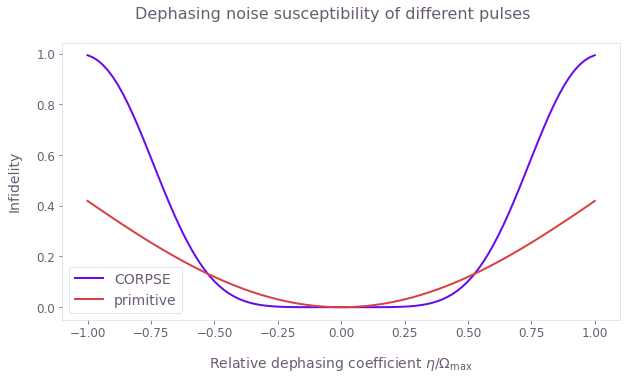

In [2]:
# Define control parameters
omega_max = 2 * np.pi * 1e6  # Hz
total_rotation = np.pi / 2

# Define coefficient array for the noise values
dephasing_coefficients = np.linspace(-1.0, 1.0, 101) * omega_max

fig = plt.figure(figsize=(10, 5))
fig.suptitle("Dephasing noise susceptibility of different pulses")

# For each scheme, compute and plot the results of the quasi-static scan
for scheme_name, function in [
    ("CORPSE", oc.new_corpse_control),
    ("primitive", oc.new_primitive_control),
]:
    # Define pulse objects using pulses from Q-CTRL Open Controls
    pulse = function(
        rabi_rotation=total_rotation, azimuthal_angle=0.0, maximum_rabi_rate=omega_max
    )

    # Create graph
    graph = bo.Graph()

    # Define Rabi coupling term
    rabi_signal = graph.pwc(
        durations=pulse.durations,
        values=pulse.rabi_rates * np.exp(1j * pulse.azimuthal_angles),
    )
    rabi_coupling_term = graph.hermitian_part(rabi_signal * graph.pauli_matrix("M"))

    # Define dephasing term, a [101] batch of operators, created by multiplying
    # a [101] batch of (constant) PWC signals by the corresponding σz/2 operator
    dephasing_signal = graph.constant_pwc(
        constant=dephasing_coefficients,
        duration=pulse.duration,
        batch_dimension_count=1,
    )
    dephasing_term = dephasing_signal * graph.pauli_matrix("Z") / 2

    # Build total Hamiltonian, a [101] batch of operators
    hamiltonian = rabi_coupling_term + dephasing_term

    # Calculate infidelities, a [101] tensor
    sqrt_sigma_x = (0.5 + 0.5j) * graph.pauli_matrix("I") + (
        0.5 - 0.5j
    ) * graph.pauli_matrix("X")

    graph.infidelity_pwc(
        hamiltonian=hamiltonian, target=graph.target(sqrt_sigma_x), name="infidelities"
    )

    # Execute the graph
    result = bo.execute_graph(graph=graph, output_node_names="infidelities")

    # Extract and plot infidelities
    infidelities = result["output"]["infidelities"]["value"]
    plt.plot(dephasing_coefficients / omega_max, infidelities, label=scheme_name)


plt.ylabel("Infidelity")
plt.xlabel(r"Relative dephasing coefficient $\eta/\Omega_\mathrm{max}$")
plt.legend()
plt.show()

##  Example: 2D pulse susceptibility to simultaneous amplitude and dephasing noise

In this example we will compare a series of composite $\pi$ pulses applied to a single qubit under amplitude and dephasing noise. The Hamiltonian of the quantum system is:
$$
H(t) = \frac{1+\beta(t)}{2}\Big( \Omega(t) \sigma_- + \Omega^*(t) \sigma_+ \Big) + \frac{\eta(t)}{2} \sigma_z  ,
$$
where $\Omega(t)$ is a time-dependent Rabi rate, $\beta(t)$ is a fractional time-dependent amplitude fluctuation process, $\eta(t)$ is a small slowly-varying stochastic dephasing noise process, $\sigma_\pm = (\sigma_x \mp i \sigma_y)/2$, and $\sigma_k$ are the Pauli matrices.

Comparing the variation in infidelity across a 2D grid of $(\beta,\eta)$ gives information about the robustness of the appropriate control to simultaneous quasi-static noise on the two channels.

We consider the following driven control schemes for the controllable $\Omega(t)$ term, which are available from [Q-CTRL Open Controls](https://github.com/qctrl/open-controls) and described in the [reference documentation](https://docs.q-ctrl.com/open-controls/references/qctrl-open-controls/qctrlopencontrols): primitive, BB1, SK1, and CORPSE. Here we invoke these controls, define relevant parameters in the system simulation, and identify the arrays defining the grid of noise coefficients in the quasi-static scan.

In [3]:
# Define schemes for driven controls to compare
schemes = {
    name: {"function": function}
    for name, function in [
        ("primitive", oc.new_primitive_control),
        ("BB1", oc.new_bb1_control),
        ("SK1", oc.new_sk1_control),
        ("CORPSE", oc.new_corpse_control),
    ]
}

# Define control parameters
total_rotation = np.pi  # Target rotation angle here is a \pi pulse.
omega_max = 2 * np.pi * 1e6  # Hz, this is the maximum Rabi rate in the system.

# Define coefficient arrays for the noise values.
# We use a grid with 51 points for $\beta\in [-0.5,0.5]$
# and 101 points for $\eta\in[-\Omega_{\mathrm{max}}, \Omega_{\mathrm{max}}]$.
amplitude_coefficients = np.linspace(-0.5, 0.5, 51)
dephasing_coefficients = np.linspace(-1.0, 1.0, 101) * omega_max

The infidelities returned by the `graph.infidelity_pwc` node are a [51, 101] tensor (based on the sizes of $(\beta,\eta)$), where each element gives the infidelity associated with a pair of amplitude and dephasing coefficient values.

In [4]:
def calculate_quasi_static_scan(pulse):
    # Create graph
    graph = bo.Graph()

    # [51, 1, T] array with values of (1+β)Ω(t) on each segment and for each value of β
    complex_rabi_rates_with_noise = (
        (1 + amplitude_coefficients[:, None, None])
        * pulse.rabi_rates
        * np.exp(1j * pulse.azimuthal_angles)
    )
    # [51, 1] batch of PWC signals for (1+β)Ω(t)
    # We specify time_dimension=2, as the PWC values array has two batching dimensions.
    rabi_signal = graph.pwc(
        values=complex_rabi_rates_with_noise,
        durations=pulse.durations,
        time_dimension=2,
    )
    # [51, 1] batch of 2×2 PWC operators for the coupling term, (1+β)[Ω(t)σ- + Ω*(t)σ+]
    rabi_coupling_term = graph.hermitian_part(rabi_signal * graph.pauli_matrix("M"))

    # [1, 101] batch of 2×2 constant (with a single segment) PWC signals for η
    dephasing_signal = graph.pwc(
        values=dephasing_coefficients[None, :, None],
        durations=np.array([pulse.duration]),
        time_dimension=2,
    )
    # [1, 101] batch of 2×2 PWC operators for the dephasing drift term, η σz/2
    dephasing_term = dephasing_signal * graph.pauli_matrix("Z") / 2

    # [51, 101] batch of 2×2 PWC operators for the total Hamiltonian,
    # with each element in the batch represents a unique pair of (β, η) values
    # (the [51, 1] and [1, 101] batches get broadcasted to [51, 101]).
    hamiltonian = rabi_coupling_term + dephasing_term

    # [51, 101] tensor with the infidelities
    graph.infidelity_pwc(
        hamiltonian=hamiltonian,
        target=graph.target(graph.pauli_matrix("X")),
        name="infidelities",
    )

    # Execute the graph
    result = bo.execute_graph(graph=graph, output_node_names="infidelities")

    # Extract and return infidelities
    return result["output"]["infidelities"]["value"]

We can now call the function for each Q-CTRL Open Controls scheme and extract the calculated infidelities.
We also store the values for the noise coefficients in the quasi-static scan to plot them later.

In [5]:
for scheme_name, scheme_objects in schemes.items():
    # Define pulse objects using pulses from Q-CTRL Open Controls
    pulse = scheme_objects["function"](
        rabi_rotation=total_rotation, azimuthal_angle=0.0, maximum_rabi_rate=omega_max
    )

    print(f"\nObtaining infidelities for {scheme_name} scheme...")

    # Create and execute the graph that calculates the infidelities
    infidelities = calculate_quasi_static_scan(pulse)

    # Save calculated infidelities
    scheme_objects["infidelities"] = infidelities

    # Save relevant quantities for later use
    scheme_objects["dephasing noise values"] = dephasing_coefficients
    scheme_objects["drive noise values"] = amplitude_coefficients


Obtaining infidelities for primitive scheme...
Your task (action_id="1828109") has completed.

Obtaining infidelities for BB1 scheme...
Your task (action_id="1828110") has completed.

Obtaining infidelities for SK1 scheme...
Your task (action_id="1828111") has started.
Your task (action_id="1828111") has completed.

Obtaining infidelities for CORPSE scheme...
Your task (action_id="1828112") has completed.


For 2D scans, density plots can provide intuitive visualizations of the noise robustness. With the grid of infidelities extracted above, it is simple to create such plots using the Matplotlib library.

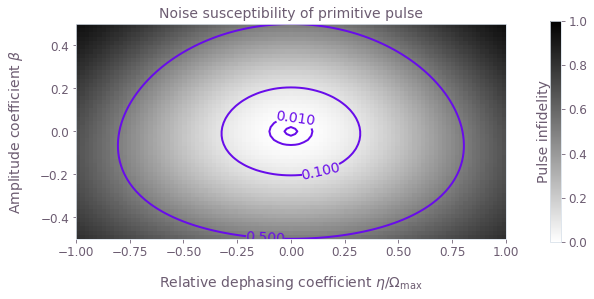

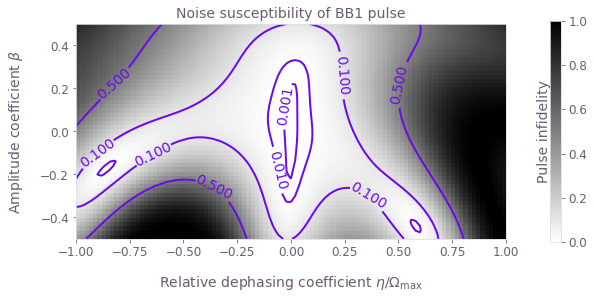

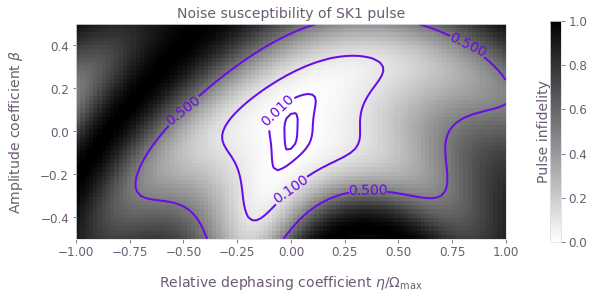

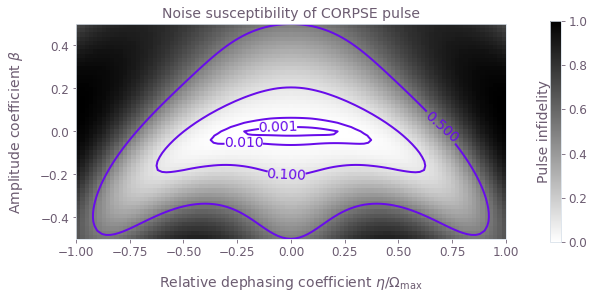

In [6]:
for scheme_name, scheme_objects in schemes.items():
    fig, ax = plt.subplots(figsize=(10, 4))

    contours = plt.contour(
        scheme_objects["dephasing noise values"] / omega_max,
        scheme_objects["drive noise values"],
        scheme_objects["infidelities"],
        levels=[0.001, 0.01, 0.1, 0.5],
        colors="#680CEA",
    )
    plt.clabel(contours, inline=True)

    plt.imshow(
        scheme_objects["infidelities"],
        extent=[
            np.min(dephasing_coefficients) / omega_max,
            np.max(dephasing_coefficients) / omega_max,
            np.min(amplitude_coefficients),
            np.max(amplitude_coefficients),
        ],
        origin="lower",
        cmap=plt.colormaps["gray"].reversed(),
        vmin=0,
        vmax=1,
    )

    cbar = plt.colorbar(pad=0.08)
    cbar.set_label("Pulse infidelity", labelpad=-50)
    plt.title(f"Noise susceptibility of {scheme_name} pulse")
    plt.ylabel(r"Amplitude coefficient $\beta$")
    plt.xlabel(r"Relative dephasing coefficient $\eta/\Omega_\mathrm{max}$")
    plt.show()

### Summary

The plots demonstrate clearly the different noise susceptibilities of the different controls. For example, the BB1 control exhibits excellent robustness to amplitude noise (it retains a low infidelity across a wide range of amplitude noise values), but low dephasing robustness (infidelity increases rapidly as the dephasing coefficient varies from zero). The CORPSE control is the opposite: it is robust to dephasing noise, but highly susceptible to amplitude noise.

We have thus demonstrated how Boulder Opal can be used to characterize the robustness of different controls to quasi-static noise on multiple simultaneous noise channels.

## Example: Combining quasi-static noise susceptibility with open quantum systems
To create quasi-static scans for a system that evolves according to a master equation, you need to employ the graph framework to obtain the points that compose the quasi-static scan. Assuming a noise process $\eta$ which changes sufficiently slowly that it is constant in each run of the gate, each point represents the performance of the pulse under different strengths of $\eta$ in combination with any open-systems dynamics.

To quantify the performance of the target control, you can use the state infidelity as a metric. Using the fact that the target state is a pure state $\rho_{\rm target}$, you can find the infidelity of a pulse that evolves the system to a state $\rho(t)$ through the formula:
$$ \mathcal{I} (t) = 1 - \left( \mathrm{Tr} \left\{ \sqrt{ \sqrt{\rho_{\rm target}} \rho(t) \sqrt{\rho_{\rm target}} } \right\} \right)^2  = 1 - \mathrm{Tr} \left\{ \rho_{\rm target} \rho(t) \right\}  . $$

For this example, consider a system under the following system Hamiltonian:
$$ H_{\rm s}(t) = \frac{1}{2} \Omega(t) \sigma_- + \frac{1}{2} \Omega^* (t) \sigma_+ + \eta \sigma_z  , $$
where $\sigma_x$, $\sigma_y$, and $\sigma_z$ are the Pauli matrices and $\sigma_\pm = (\sigma_x \mp i \sigma_y)/2$. The signal $\Omega(t)$ represents your complex-valued controls, while $\eta$ is the noise coefficient. 

Consider as well that the system can longitudinally relax at a certain rate $T_1$, so that the complete GKS–Lindblad master equation that describes its evolution is:
$$ \frac{\mathrm{d}}{\mathrm{d} t} \rho(t) = - i \left[ H_{\rm s}(t), \rho(t) \right] + \frac{1}{T_1} \sigma_- \rho(t) \sigma_+ - \frac{1}{2} \frac{1}{T_1} \left\{ \rho(t), \sigma_+ \sigma_- \right\}  . $$
In this master equation, $\sigma_-$ is the Lindblad operator with an associated rate $1/T_1$.

To see how a set of pulses performs against additive quasi-static $\sigma_z$ noise, when also subject to incoherent $T_1$ processes, you can use the open system tools to calculate the evolution of the master equation for different values of $\eta$. This example shows how you can create an [optimized pulse](https://docs.q-ctrl.com/boulder-opal/tutorials/design-robust-single-qubit-gates-using-computational-graphs) under these conditions by setting the sum of the infidelities under different quasi-static strengths as the cost function of the optimization. The code block below compares the performance of the predefined pulse and the optimized pulse, plotting the shape of the controls and the quasi-static scans for both of them.

Your task (action_id="1828114") has started.
Your task (action_id="1828114") has completed.


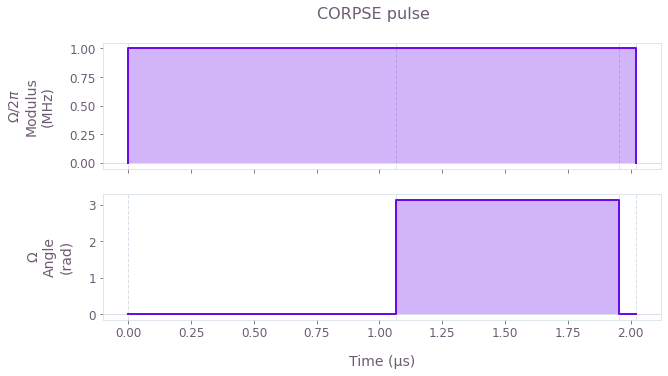

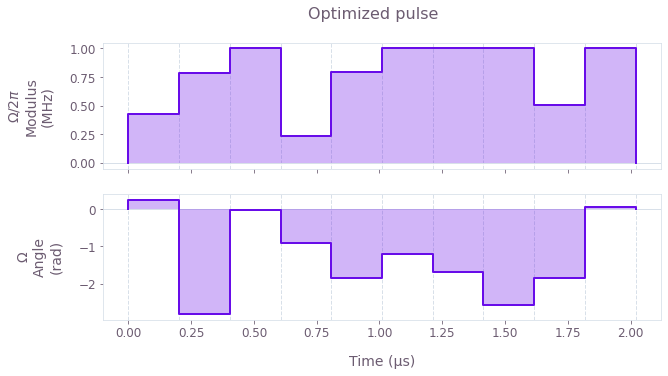

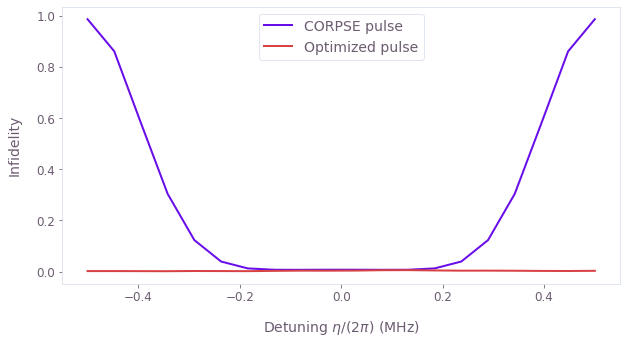

In [7]:
# Define noise and control parameters.
T1 = 100e-6  # s
omega_max = 2 * np.pi * 1e6  # Hz
total_rotation = np.pi / 2

# Define scan parameters
scan_point_count = 20
scan_range = np.linspace(-omega_max / 2, omega_max / 2, scan_point_count)

# Obtain predefined pulse from Q-CTRL Open Controls.
corpse_pulse = oc.new_corpse_control(
    rabi_rotation=total_rotation, azimuthal_angle=0.0, maximum_rabi_rate=omega_max
)
duration = sum(corpse_pulse.durations)

# Create optimization graph.
graph = bo.Graph()

# Define standard matrices


initial_density_matrix = np.array([[1, 0], [0, 0]])
target_operator = (graph.pauli_matrix("I") - 1j * graph.pauli_matrix("X")) / np.sqrt(2)
target_density_matrix = (
    target_operator @ initial_density_matrix @ graph.adjoint(target_operator)
)

# Define the controls for the predefined pulse.
corpse_omega = graph.pwc(
    values=corpse_pulse.rabi_rates * np.exp(1j * corpse_pulse.azimuthal_angles),
    durations=corpse_pulse.durations,
    name="corpse_pulse",
)

# Define controls for the optimized pulse.
optimized_omega = graph.complex_optimizable_pwc_signal(
    segment_count=10, maximum=omega_max, duration=duration, name="optimized_pulse"
)

# Create control Hamiltonians for the predefined pulse and the optimized pulse.
noiseless_corpse_hamiltonian = graph.hermitian_part(
    corpse_omega * graph.pauli_matrix("M")
)
noiseless_optimized_hamiltonian = graph.hermitian_part(
    optimized_omega * graph.pauli_matrix("M")
)

# Create list of detuning terms for the quasi-static scan.
scan_terms = [amplitude * graph.pauli_matrix("Z") for amplitude in scan_range]

# Add detuning terms to the control Hamiltonians.
corpse_hamiltonians = [
    noiseless_corpse_hamiltonian + scan_term for scan_term in scan_terms
]
optimized_hamiltonians = [
    noiseless_optimized_hamiltonian + scan_term for scan_term in scan_terms
]

# Define decay term of the master equation.
lindblad_operator = np.array([[0.0, 1.0], [0.0, 0.0]])

# Calculate the final density matrices from the master equation.
corpse_density_matrices = [
    graph.density_matrix_evolution_pwc(
        initial_density_matrix=initial_density_matrix,
        hamiltonian=corpse_hamiltonian,
        lindblad_terms=[(1 / T1, lindblad_operator)],
        sample_times=np.array([duration]),
        error_tolerance=None,
    )[-1]
    for corpse_hamiltonian in corpse_hamiltonians
]
optimized_density_matrices = [
    graph.density_matrix_evolution_pwc(
        initial_density_matrix=initial_density_matrix,
        hamiltonian=optimized_hamiltonian,
        lindblad_terms=[(1 / T1, lindblad_operator)],
        sample_times=np.array([duration]),
        error_tolerance=None,
    )[-1]
    for optimized_hamiltonian in optimized_hamiltonians
]

# Calculate infidelities with respect to the target.
corpse_infidelities = [
    graph.density_matrix_infidelity(
        density_matrix, target_density_matrix, name=f"corpse_infidelity{number}"
    )
    for number, density_matrix in enumerate(corpse_density_matrices)
]
optimized_infidelities = [
    graph.density_matrix_infidelity(
        density_matrix, target_density_matrix, name=f"optimized_infidelity{number}"
    )
    for number, density_matrix in enumerate(optimized_density_matrices)
]

# Create cost as the sum of all the infidelities of the optimized pulse.
graph.sum(optimized_infidelities, name="cost")

# Run optimization.
results = bo.run_optimization(
    graph=graph,
    cost_node_name="cost",
    output_node_names=["corpse_pulse", "optimized_pulse"]
    + [f"corpse_infidelity{number}" for number in range(scan_point_count)]
    + [f"optimized_infidelity{number}" for number in range(scan_point_count)],
    optimization_count=4,
)

# Plot pulses.
qv.plot_controls({r"$\Omega$": results["output"]["corpse_pulse"]})
plt.suptitle("CORPSE pulse")

qv.plot_controls({r"$\Omega$": results["output"]["optimized_pulse"]})
plt.suptitle("Optimized pulse")

# Plot quasi-static scan.
figure = plt.figure()
plt.xlabel(r"Detuning $\eta$/(2$\pi$) (MHz)")
plt.ylabel("Infidelity")
plt.plot(
    scan_range * 1e-6 / (2 * np.pi),
    [
        results["output"][f"corpse_infidelity{number}"]["value"]
        for number in range(scan_point_count)
    ],
    label="CORPSE pulse",
)
plt.plot(
    scan_range * 1e-6 / (2 * np.pi),
    [
        results["output"][f"optimized_infidelity{number}"]["value"]
        for number in range(scan_point_count)
    ],
    label="Optimized pulse",
)
plt.legend()
plt.show()